<h1>POS total health score and asssociated health supports</h1>
<h4>Version : 0.9</h4>
<h4>14/5/22</h4>

><i>As the concept of quality of life (QOL) has evolved from a philosophical concept to both a measurable construct and an action-oriented change agent, there has emerged in the field a corresponding need to develop, implement, and use a systematic approach to the assessment of domain-referenced quality of life outcomes ... these outcomes can be used for multiple purposes at both the individual and organization level. The Personal Outcomes Scale (POS) represents one such assessment approach to the measurement of QOL outcomes\\(.{^1}\\)</i>

For more technical detail on how the POS is constructed and the theory behind it please see the manual or references papers below \\(.{^1}\\)
<br>
In this notebook we will look at one of the three <i>organization</i> level outputs detailed in the POS manual
<br><br>
Organisation level output 2:
<br>
><i>Determine which individual, organization-referenced, and community factors predict outcome scores. (Evidence-Based Practices)\\(.{^1}\\)</i>
<p>
Using the total score from the health (“physical” in POS literature.) domain can we observe differences in the mean total health score in different groups of people we support based on whether they receive specific health supports?</p>
<p>
E.G. Is there a difference in mean total health score for people who do and do not receive support in areas such as taking medication or with diabetes. 
</p><br><br>

1. https://hcpbs.org/wp-content/uploads/2018/10/vanloonposmanual.pdf

In [0]:
# Import packages needed for this analysis
import pandas as pd
import numpy as np
import statistics as stats
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
# Turning off errors for slice warning, need to understand this more. It doesn't affect code or logic (even if left on) but... should know why it is bad practice rather than just turning off the warning.
pd.options.mode.chained_assignment = None  # default='warn'

In [0]:
#Load the main table, eventually this should be a syntethic data set we can release with this notebook. 
df = spark.table("poswidedataset")
#We're using Databricks so change from spark dataframe to pandas
df = df.toPandas()
#drop all columns apart from below
df = df[['HealthTotal','NoP_SW_HE_Epilepsy','NoP_SW_HE_Health','NoP_SW_HE_Medication','NoP_SW_HE_Diabetes','NoP_SW_HE_SaLT','Reports']]
#Make the column names a bit easier and camelcase
df = df.rename(columns={"NoP_SW_HE_Epilepsy": "SWEpilepsy", "NoP_SW_HE_Health": "SWHealth", "NoP_SW_HE_Medication": "SWMedication", "NoP_SW_HE_Diabetes": "SWDiabetes", "NoP_SW_HE_SaLT": "SWSaLT", "Reports": "report", "HealthTotal": "healthTotal"})
#Drop rows where we don't have support data, this is for v.recent where supports have not yet been updated.
df = df.dropna()
#Create an ID, not needed in this notebook but needed for synthetic dataset creation
df["id"] = df.index + 1
#Example of fields
df.head()

Out[3]:

,healthTotal,SWEpilepsy,SWHealth,SWMedication,SWDiabetes,SWSaLT,report,id
6,17,False,True,False,False,False,SelfReport,7
7,15,False,True,True,False,False,SelfReport,8
8,15,False,True,False,False,False,OtherReport,9
9,18,False,True,False,False,False,SelfReport,10
10,16,False,True,False,False,False,SelfReport,11


<h4> Health supports & data</h4>
<p>We will pull in 7 fields :</p><br>
  
 * healthTotal
 * SWEpilepsy
 * SWHealth
 * SWMedication
 * SWDiabetes
 * SWSaLT 
 * report</p>

<p>healthTotal - Total POS score in the health (physical) domain. There are 6 questions on a three point likert scale. The most positive response scores three points, this number is answers added together<p>
<p>SWEpilepsy - Supported with Epilepsy: if someone has a diagnosis of having epilepsy and we provide support to them we would have a support plan to show how epilepsy may look and how we would support during this. Someone with epilepsy may also have a support plan/ epilepsy pen picture from a epilepsy nurse.</p>
<p> SWHealth - Supported with Health: When someone needs support to attend health appointments, understand outcomes of a health appointment and is unable to comprehend or explain outcomes from a health appointment.A health support plan may also detail any health issues someone has or diagnosis.</p>
<p>SWMedication - Supported with Medication: when someone is unable to look after or take medicines at the right time or in the right way, we would support this and the storage, stock control and administration of this. If we support someone with medicine, there would be a support plan to show how this is done.</p>
<p>SWDiabetes - Supported with Diabetes: If someone has a diagnosis of Diabetes it means blood sugar drops low or goes to high. Elevated levels of blood glucose can have lasting damage to the heart, blood vessels, eyes, kidneys, and nerves. Diabetes can be managed through diet or medicines.</p>
<p>SWSaLT - Supported with Speech and language therapy: When someone has swallowing/ chewing issues with food and can also be drink, leading to a risk of choking or aspirating a speech and language therapist will carry out an assessment and give food preparation guidance.</p>
<p>report: Whether the subject of the POS conversation answered for themselves (SelfReport) or if they lacked capacity or wished for someone else to answer for them (OtherReport).</p>

In [0]:
#Definting functions here for reusibility.
#We're comparing two groups, ordinarily we'd use a T-Test but the data is largely non parametric. We've built a two functions. The first tests whether the data is parametric. The second is an equiuvalent two tail test that doesn't assume parametric data. 

def normalTest(report,target):
  global statsTableL
  statsTableL = statsTable.loc[statsTable.report == report]
  for index, row in statsTableL.iterrows():
     
    dfN = df.loc[df.report == report]
    field = statsTable['variable'].iloc[index]
    group1Value = statsTable['group1Value'].iloc[index]
    group2Value = statsTable['group2Value'].iloc[index]

    posGroup1 = dfN[dfN[field] == group1Value]
    posGroup1 = posGroup1[target]
    posGroup2 = dfN[dfN[field] == group2Value]
    posGroup2 = posGroup2[target]

    stat, p = shapiro(posGroup1)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret

    alpha = 0.05
    statsTable.iat[index, statsTable.columns.get_loc('group1Pop')]= len(posGroup1)
    statsTable.iat[index, statsTable.columns.get_loc('group1Mean')]= stats.mean(posGroup1)
    statsTable.iat[index, statsTable.columns.get_loc('group2Pop')]= len(posGroup2)
    statsTable.iat[index, statsTable.columns.get_loc('group2Mean')]= stats.mean(posGroup2)

    if p > alpha:
        print('%s %s looks normal/Gaussian (fail to reject H0) according to Shapiro-Wilk Test' % (field,group1Value))
        statsTable.iat[index, statsTable.columns.get_loc('group1Normal')]='True'
    else:
        print('%s %s does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test' % (field,group1Value))
        statsTable.iat[index, statsTable.columns.get_loc('group1Normal')]='False'

    ax = posGroup1.plot.hist(bins=12, alpha=0.2)
    # df.iloc[index]["group1Mean"] = "True"
    print("")

    stat, p = shapiro(posGroup2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('%s %s looks normal/Gaussian (fail to reject H0) according to Shapiro-Wilk Test' % (field,group2Value))
        statsTable.iat[index, statsTable.columns.get_loc('group2Normal')]='True'

    else:
        print('%s %s does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test' % (field,group2Value))
        statsTable.iat[index, statsTable.columns.get_loc('group2Normal')]='False'

    ax = posGroup1.plot.hist(bins=12, alpha=0.2)


    print("")

In [0]:
#Eventually I'd like to put in logic here that will chose either T-Test or Mann Whitney based on the results of the first test the parametric distribution

def MWTest(report,target):
  global statsTableL
  statsTableL = statsTable.loc[statsTable.report == report]
  for index, row in statsTableL.iterrows():
    dfP = df.loc[df.report == report]
    field = statsTable['variable'].iloc[index]
    group1 = statsTable['group1Value'].iloc[index]
    group2 = statsTable['group2Value'].iloc[index]

    posGroup1 = dfP[dfP[field] == group1]
    posGroup1 = posGroup1[target]
    posGroup2 = dfP[dfP[field] == group2]
    posGroup2 = posGroup2[target]

    stat, p = mannwhitneyu(posGroup1, posGroup2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    statsTable.iat[index, statsTable.columns.get_loc('P')]= p
    if p > alpha:
        print('%s %s Same distribution (fail to reject H0)' % (field,group1))
        statsTable.iat[index, statsTable.columns.get_loc('sigDif')]='False'
    else:
        print('%s %s Different distribution (reject H0)' % (field,group1))
        statsTable.iat[index, statsTable.columns.get_loc('sigDif')]='True'

In [0]:
#This drives the parameters for the loop in the function
data = [
        ['SWHealth', 'True','False','SelfReport'],
        ['SWSaLT', 'True','False','SelfReport'],
        ['SWEpilepsy', 'True','False','SelfReport'],
        ['SWDiabetes', 'True','False','SelfReport'],
        ['SWMedication', 'True','False','SelfReport'],
        ['SWSaLT', 'True','False','OtherReport'],
        ['SWEpilepsy', 'True','False','OtherReport'],
        ['SWDiabetes', 'True','False','OtherReport'],
        ['SWMedication', 'True','False','OtherReport'],
       ]

#what should we be testing the mean of
target = 'healthTotal'

# Create the pandas DataFrame to put the stats into
statsTable = pd.DataFrame(data, columns = ['variable', 'group1Value','group2Value','report'])

statsTable['group1Normal'] = ""
statsTable['group2Normal'] = ""
statsTable['group1Pop'] = 0
statsTable['group2Pop'] = 0
statsTable['group1Mean'] = 0.0
statsTable['group2Mean'] = 0.0
statsTable['sigDif'] = ""
statsTable['P'] = 0.0

Statistics=0.958, p=0.000
SWHealth True does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.958, p=0.355
SWHealth False looks normal/Gaussian (fail to reject H0) according to Shapiro-Wilk Test

Statistics=0.929, p=0.209
SWSaLT True looks normal/Gaussian (fail to reject H0) according to Shapiro-Wilk Test

Statistics=0.957, p=0.000
SWSaLT False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.838, p=0.001
SWEpilepsy True does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.963, p=0.000
SWEpilepsy False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.910, p=0.042
SWDiabetes True does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.961, p=0.000
SWDiabetes False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.966, p=0.002
SWMedication True does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.922, p=0.001
SWMedication False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.956, p=0.142
SWSaLT True looks normal/Gaussian (fail to reject H0) according to Shapiro-Wilk Test

Statistics=0.924, p=0.001
SWSaLT False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.957, p=0.169
SWEpilepsy True looks normal/Gaussian (fail to reject H0) according to Shapiro-Wilk Test

Statistics=0.948, p=0.012
SWEpilepsy False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.941, p=0.670
SWDiabetes True looks normal/Gaussian (fail to reject H0) according to Shapiro-Wilk Test

Statistics=0.954, p=0.003
SWDiabetes False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.953, p=0.003
SWMedication True does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

Statistics=0.817, p=0.023
SWMedication False does not look normal/Gaussian (reject H0) according to Shapiro-Wilk Test

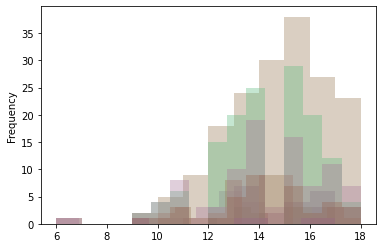

In [0]:
#test whether data is parametric, eventually should refactor this so it only needs to get called once
report= 'SelfReport'
normalTest(report,target)
report= 'OtherReport'
normalTest(report,target)

In [0]:
#test whether for difference in scores, eventually should refactor this so it only needs to get called once
report= 'SelfReport'
MWTest(report,target)
report= 'OtherReport'
MWTest(report,target)

Statistics=2002.000, p=0.140
SWHealth True Same distribution (fail to reject H0)
Statistics=1540.000, p=0.430
SWSaLT True Same distribution (fail to reject H0)
Statistics=2011.000, p=0.305
SWEpilepsy True Same distribution (fail to reject H0)
Statistics=1557.000, p=0.025
SWDiabetes True Different distribution (reject H0)
Statistics=3988.000, p=0.085
SWMedication True Same distribution (fail to reject H0)
Statistics=870.000, p=0.031
SWSaLT True Different distribution (reject H0)
Statistics=1074.500, p=0.431
SWEpilepsy True Same distribution (fail to reject H0)
Statistics=212.000, p=0.386
SWDiabetes True Same distribution (fail to reject H0)
Statistics=433.000, p=0.493
SWMedication True Same distribution (fail to reject H0)

In [0]:
#Results
statsTable

Out[9]:

,variable,group1Value,group2Value,report,group1Normal,group2Normal,group1Pop,group2Pop,group1Mean,group2Mean,sigDif,P
0,SWHealth,True,False,SelfReport,False,True,177,26,14.237288,14.769231,False,0.140001
1,SWSaLT,True,False,SelfReport,True,False,17,186,14.294118,14.306452,False,0.429822
2,SWEpilepsy,True,False,SelfReport,False,False,24,179,14.375000,14.296089,False,0.304569
3,SWDiabetes,True,False,SelfReport,False,False,23,180,13.434783,14.416667,True,0.025258
4,SWMedication,True,False,SelfReport,False,False,137,66,14.197080,14.530303,False,0.084584
5,SWSaLT,True,False,OtherReport,True,False,38,59,13.868421,14.508475,True,0.030711
6,SWEpilepsy,True,False,OtherReport,True,False,36,61,14.277778,14.245902,False,0.431119
7,SWDiabetes,True,False,OtherReport,True,False,5,92,13.800000,14.282609,False,0.386490
8,SWMedication,True,False,OtherReport,False,False,87,10,14.287356,14.000000,False,0.492827


<h4>Results</h4>
<p>The difference in mean health totals is currently low between people who receive and do not receive each support, this by itself is good. The pandemic affected the ability to interview people so the dataset is smaller than we initially planned. With more people included these results may change.</p>
<p>There are two significant differences in diabetes for self report and SaLT in report of other.</p>
<p>Further analysis with more interviews and demographic data included is needed to draw any conclusions. We should also analyse these factors together to produce a regression model.</p>